# Chroma Normalization

Computing the chroma values with `audioflux.CQT` results in internal normalization of the chroma values. That means, when applied to small chunks, it tends to detect strong notes even in soft white noise.

How does the chroma value normalization work? And can we replace it, e.g. with a running average normalization term?

**Conclusion:**
- use `norm_type=ChromaDataNormalType.P1`
- or use `norm_type=ChromaDataNormalType.None`, then threshold the chroma (all where(<=1) = 0), then apply own frame-wise max.

In [128]:
import numpy as np
import librosa
import audioflux as af
import matplotlib.pyplot as plt
from audioflux.display import fill_spec
from audioflux.type import (SpectralFilterBankScaleType, SpectralFilterBankStyleType, SpectralFilterBankNormalType, ChromaDataNormalType, SpectralDataType)
from audioflux.utils import note_to_hz
import IPython.display as ipd
import plotly.express as px
import pandas as pd

### Load audio

In [136]:
# 880Hz tone
#sample_path = af.utils.sample_path('880')
#y, sr = af.read(sample_path)

In [137]:
# midi file (increasing notes over one octave)
y, sr = af.read("audio/midi_chunk/midi_chunk_oneoctave_c2plus.wav")

### Audio details

In [138]:
print(
    f"{y.shape} samples\n",
    f"{sr} sample rate\n",
    f"{y.shape[0] / sr} seconds\n",
    f"{y.max()} / {y.min()} min/max"
)

(164992,) samples
 44100 sample rate
 3.7413151927437642 seconds
 0.107757568359375 / -0.092315673828125 min/max


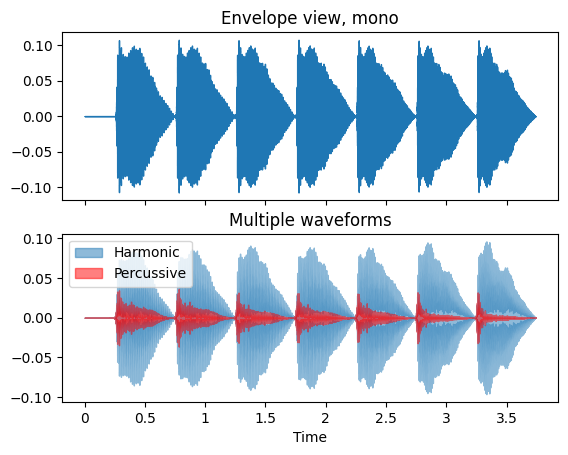

In [139]:
y_harm, y_perc = librosa.effects.hpss(y)

fig, ax = plt.subplots(nrows=2, sharex=True)
librosa.display.waveshow(y, sr=sr, axis="m", ax=ax[0])
ax[0].set(title='Envelope view, mono')
ax[0].label_outer()
librosa.display.waveshow(y_harm, sr=sr, alpha=0.5, ax=ax[1], label='Harmonic')
librosa.display.waveshow(y_perc, sr=sr, color='r', alpha=0.5, ax=ax[1], label='Percussive')
ax[1].set(title='Multiple waveforms')
ax[1].legend()

In [140]:
ipd.Audio(y, rate=sr)

### Chroma CQT

In [209]:
# 3. Extract chroma and display energies over time
cqt_obj = af.CQT(num=84, samplate=sr, low_fre=note_to_hz('C1'), bin_per_octave=12, slide_length=1024, normal_type=SpectralFilterBankNormalType.AREA)
# SpectralFilterBankNormalType.NONE | AREA | BAND_WIDTH
y_cqt = cqt_obj.cqt(y)
print(y_cqt.min(), y_cqt.max())

(-2.205166+0.22584125j) (2.2757485+0.4515467j)


#### Normalized chromagram

0.0001357191 1.0


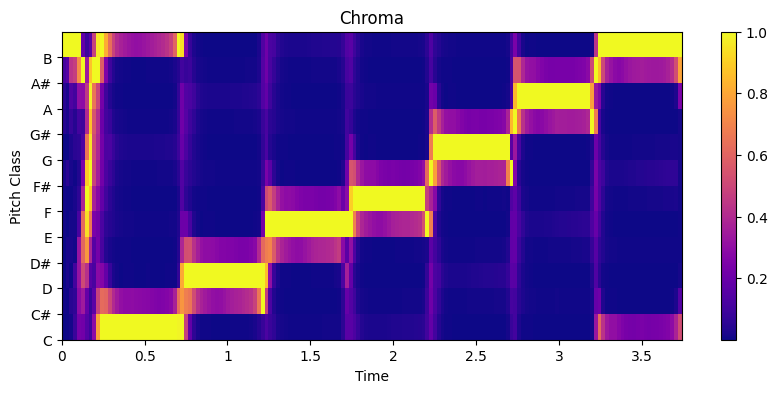

In [220]:
y_chroma_normed = cqt_obj.chroma(y_cqt, chroma_num=12, data_type=SpectralDataType.POWER, norm_type=ChromaDataNormalType.MAX)
print(y_chroma_normed.min(), y_chroma_normed.max())

fig, ax = plt.subplots(figsize=(10, 4))
img = fill_spec(y_chroma_normed, axes=ax,
                x_coords=cqt_obj.x_coords(y.shape[-1]),
                x_axis='time',
                title='Chroma')
ax.set_ylabel('Pitch Class')
ax.set_yticks(range(12))
ax.set_yticklabels(['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
fig.colorbar(img, ax=ax)

The notes are clearly distinguishable. Only before the onset of the first note do we observe some noise.

And we notice: Chroma gets max-normed for each frame! aka `y_chroma[:,0] /= y_chroma[:,0].max()`

#### Non-normalized chromagram
`CQT.chroma()`offers a number of normalization options: `ChromaDataNormalType.NONE|MAX|MIN|P1|P2`.

1.31612e-08 7.8029203


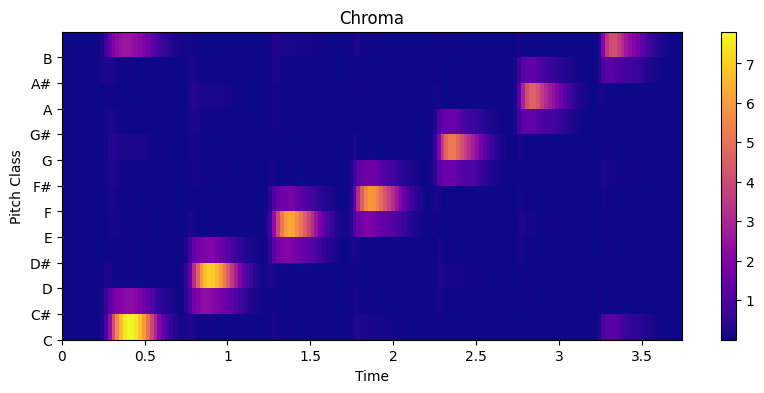

In [211]:
y_chroma_nnormed = cqt_obj.chroma(y_cqt, chroma_num=12, data_type=SpectralDataType.POWER, norm_type=ChromaDataNormalType.NONE)
# ChromaDataNormalType.NONE|MAX|MIN|P1|P2
print(y_chroma_nnormed.min(), y_chroma_nnormed.max())

fig, ax = plt.subplots(figsize=(10, 4))
img = fill_spec(y_chroma_nnormed,
                axes=ax,
                x_coords=cqt_obj.x_coords(y.shape[-1]),
                x_axis='time',
                title='Chroma')
ax.set_ylabel('Pitch Class')
ax.set_yticks(range(12))
ax.set_yticklabels(['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
fig.colorbar(img, ax=ax)

The notes are still clearly destinguishable, though not as crisp as before. Attack, onset, and decay are diustinguishable.

#### P1/P2-normalized chromagram

0.00010478556 0.792824


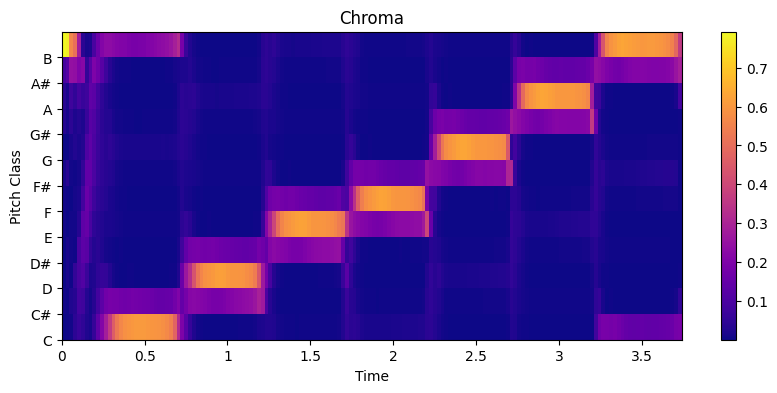

In [212]:
y_chroma_pnormed = cqt_obj.chroma(y_cqt, chroma_num=12, data_type=SpectralDataType.POWER, norm_type=ChromaDataNormalType.P1)
# ChromaDataNormalType.NONE|MAX|MIN|P1|P2
print(y_chroma_pnormed.min(), y_chroma_pnormed.max())

fig, ax = plt.subplots(figsize=(10, 4))
img = fill_spec(y_chroma_pnormed,
                axes=ax,
                x_coords=cqt_obj.x_coords(y.shape[-1]),
                x_axis='time',
                title='Chroma')
ax.set_ylabel('Pitch Class')
ax.set_yticks(range(12))
ax.set_yticklabels(['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
fig.colorbar(img, ax=ax)

- P1: Notes are clearly visible. Some artifacts in the first frame(s). Some artifacts in the end of each node.
- P2: Same, but stronger magnitude everywhere. Rather P1, I think.

These settings could help. But:
1. How will they work on small chunks, as they won't know about the preceeding chunks?
2. Artifacts at the end of the notes' decay are annoying.

#### Computing the recent average normalization factor
We can try to compute the recent average ourselves. For example, we average over the last 5 chunks their maximum values and use this as normalization factor.

Pseudocode:
```
alpha = 0.5
norm_current = 1

for chunk in chunks:
    norm_current = (1 - alpha) * norm_current + alpha * chunk.max()
    chunk_normed = (chunk / norm_current).clip(0, 1)
```

In [213]:
# implementation for this example, using convolution to simulate something like the pseudo-code
l = 10
#kernel = [1] * l + [1] + [0] * l
kernel = np.concat([np.linspace(0, 1, l+1), [0] * l])
#kernel = [0, 0, 0, 0, 1, 0, 0, 0, 0]

const = y_chroma_nnormed.max()
norm_factors = np.convolve(
        np.pad(y_chroma_nnormed.max(0), len(kernel) // 2, constant_values=const),
        kernel[::-1],
        mode="valid"
    ) / np.sum(kernel)

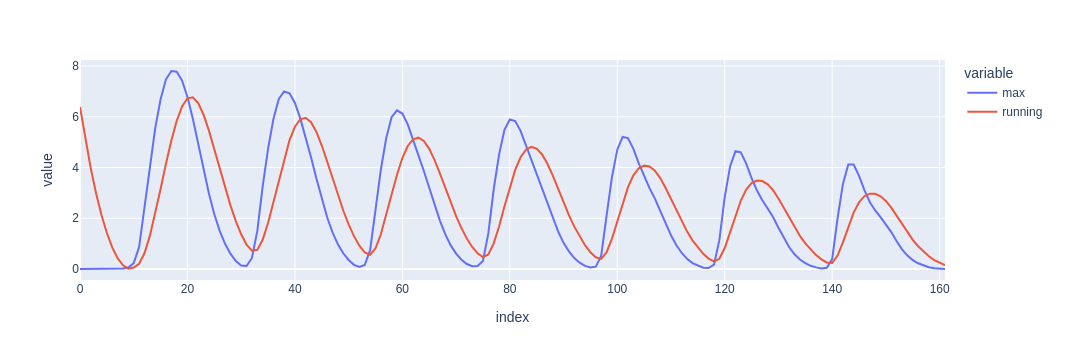

In [214]:
px.line(pd.DataFrame({"max": y_chroma_nnormed.max(0), "running": norm_factors}))

As expected, we observe a slight delay in picking up the new max values per frame. In general, we also go less high and less low. Some smoothing effect.

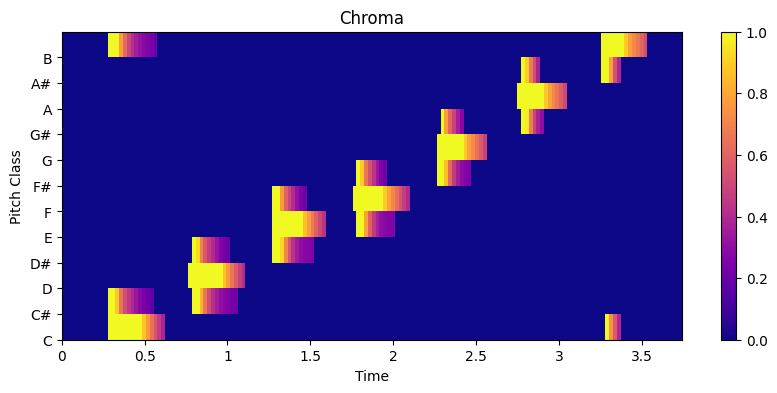

In [215]:
y_chroma_nnormed_thr = y_chroma_nnormed.copy()
y_chroma_nnormed[y_chroma_nnormed < 1] = 0

fig, ax = plt.subplots(figsize=(10, 4))
img = fill_spec((y_chroma_nnormed / norm_factors).clip(0, 1),
                axes=ax,
                x_coords=cqt_obj.x_coords(y.shape[-1]),
                x_axis='time',
                title='Chroma')
ax.set_ylabel('Pitch Class')
ax.set_yticks(range(12))
ax.set_yticklabels(['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
fig.colorbar(img, ax=ax)

Doesn't look that good, I fear :/

ANd I had to threshold before. Maybe P2 is better solution?

#### Threshold, then max-norm

/tmp/ipykernel_30078/1788620357.py:5: RuntimeWarning:

invalid value encountered in divide



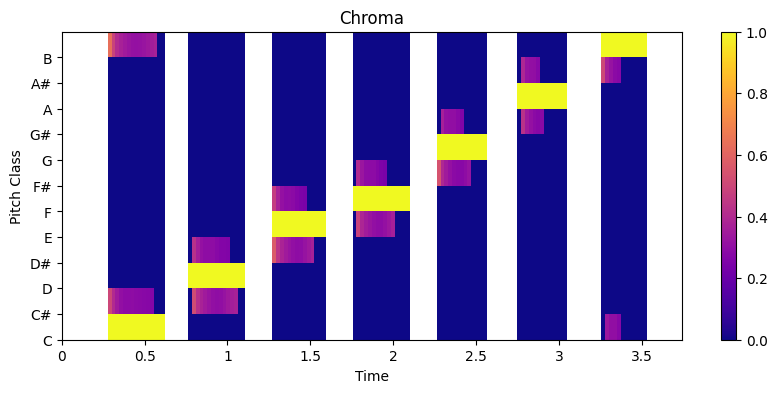

In [218]:
y_chroma_nnormed_thr = y_chroma_nnormed.copy()
y_chroma_nnormed[y_chroma_nnormed < 1] = 0

fig, ax = plt.subplots(figsize=(10, 4))
img = fill_spec((y_chroma_nnormed / y_chroma_nnormed.max(0)).clip(0, 1),
                axes=ax,
                x_coords=cqt_obj.x_coords(y.shape[-1]),
                x_axis='time',
                title='Chroma')
ax.set_ylabel('Pitch Class')
ax.set_yticks(range(12))
ax.set_yticklabels(['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
fig.colorbar(img, ax=ax)

This looks actually pretty nice :)